## Supervised Methods

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn import neighbors, ensemble, svm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score,  roc_curve, roc_auc_score, classification_report

In [ ]:
df = pd.read_csv('Data/Pipeline_data_toy_bin.csv', index_col=[0])
#df = pd.read_csv('Data/Pipeline_data_bin.csv', index_col=[0])

df.head()

In [ ]:
X = df.drop(['birthweight_bin'], axis=1)
y = df['birthweight_bin']

* Variance Threshold used to remove features with low variance 

In [ ]:
selector = VarianceThreshold(threshold = 0.1)
X_new = selector.fit_transform(X)

In [ ]:
X_new.shape

In [ ]:
X.columns

In [ ]:
features = X.columns
features[selector.get_support()]

* Feature selection

In [ ]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
X_new = fs.fit_transform(X, y)

In [ ]:
X.columns

In [ ]:
features = X.columns
features[fs.get_support()]

In [ ]:
X = X[['cigs_before_preg', 'm_height_in', 'num_prenatal_visits',
       'prior_births_dead', 'prior_terminations', 'prepreg_weight',
       'time_since_menses', 'birth_attendant', 'birth_place', 'birth_dy',
       'f_education', 'f_race6', 'gonorrhea', 'labour_induced', 'm_nativity',
       'm_education', 'm_hispanic', 'admit_icu', 'm_race6', 'm_transferred',
       'infections', 'm_morbidity', 'riskf', 'payment',
       'mn_prenatalcare_began', 'delivery_method', 'res_status',
       'prev_cesarean', 'infant_sex', 'weight_change']]

### Pre-processing

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
num_cols = ('cigs_before_preg','m_height_in','num_prenatal_visits','prior_births_dead','prior_terminations',
            'prepreg_weight','time_since_menses','weight_change','mn_prenatalcare_began')

bin_cols = ('gonorrhea','labour_induced','admit_icu','m_transferred','infections','m_morbidity','riskf',
            'prev_cesarean','infant_sex')

cat_cols = ('birth_attendant','birth_place','birth_dy','f_education','f_race6','m_nativity','m_education',
            'm_hispanic','m_race6','payment','delivery_method','res_status')

In [ ]:
#num_cols = ('bmi','cigs_before_preg','birth_time','m_deliveryweight','f_age','m_age','m_height_in',
#            'num_prenatal_visits','prior_births_dead','prior_births_living','prior_terminations','prepreg_weight',
#            'num_prev_cesareans','time_since_menses','weight_change','mn_prenatalcare_began')

#bin_cols = ('gonorrhea','labour_induced','admit_icu','m_transferred','infections','m_morbidity','riskf',
#            'prev_cesarean','infant_sex')

#cat_cols = ('birth_attendant','birth_place','birth_mn','birth_dy','f_education','f_hispanic','f_race6',
#                'm_nativity','m_education','m_hispanic','m_race6','payment','delivery_method','res_status')

In [ ]:
num_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first'))])


preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('num', num_transformer , num_cols),
            ('cat', cat_transformer , cat_cols)
        ])

In [ ]:
X_processed = preprocessor.fit_transform(X)

In [ ]:
X_processed = pd.DataFrame(X_processed)

In [ ]:
X_processed.head()

In [ ]:
pca = PCA().fit(X_processed)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_processed)

In [ ]:
# Extract the projections of the first 2 components
pca2 = X_pca[:, :2]

# Plot the first 2 components
principalDf = pd.DataFrame(data = pca2, 
                           columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([y, principalDf], axis = 1)
finalDf.columns = ['labels', 'principal component 1', 'principal component 2']

ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue='labels', data=finalDf)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

### Logistic Regression

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

# fit a model
logm = LogisticRegression(solver='lbfgs', penalty='none')
logm.fit(X_train, y_train)

# predict probabilities
lr_probs = logm.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
y_pred = logm.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

### KNN

In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

In [ ]:
y_pred = knn.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
print('Number of low-bw cases in test set =', cm[1,0] + cm[1,1])
print('Number of correctly predicted low-bw cases =', cm[1,1])

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

In [ ]:
clf = GridSearchCV(estimator=neighbors.KNeighborsClassifier(), param_grid={'n_neighbors': range(1, 25)})

clf.fit(X_train, y_train)

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
knn_probs = knn.predict_proba(X_test)

# keep probabilities for the positive outcome only
knn_probs = knn_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
X_processed_svm = X[['num_prenatal_visits','cigs_before_preg']]

In [ ]:
sns.scatterplot(X_processed_svm['cigs_before_preg'], X_processed_svm['num_prenatal_visits'], hue=y);

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_processed_svm, y, test_size=0.2, random_state=0)

In [ ]:
def plot_svc_decision_function(model, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    X, Y = np.meshgrid(x,y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    

    ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(estimator=SVC(), param_grid={'C': [8, 9, 10], 'gamma': [0.02, 0.03, 0.04]})

clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
svm = SVC(gamma=0.03, kernel='rbf', C=9, probability=True)
svm.fit(X_train, y_train)

In [ ]:
y_pred = svm.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
print('Number of low-bw cases in test set =', cm[1,0] + cm[1,1])
print('Number of correctly predicted low-bw cases =', cm[1,1])

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
svm_probs = svm.predict_proba(X_test)

# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (svm_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Linear Discriminant Analysis

In [ ]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_f, y_train_f)

In [ ]:
y_pred = lda.predict(X_test_f)

cm = metrics.confusion_matrix(y_test_f, y_pred_f)
print(cm)

In [ ]:
print('Number of low-bw cases in test set =', cm[1,0] + cm[1,1])
print('Number of correctly predicted low-bw cases =', cm[1,1])

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

### Decision tree

In [56]:
# preamble
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

import graphviz 

# Helper function to plot the decision tree. This uses the graphviz library.
def plot_tree(graph, feature_names=None, class_names=None):
    '''
    This method takes a DecisionTreeClassifier object, along with a list of feature names and target names
    and plots a tree. The feature names and class names can be left empty; they are just there for labelling 
    '''
    dot_data = export_graphviz(graph, out_file=None, 
                      feature_names=feature_names,  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True) 
    
    graph = graphviz.Source(dot_data)
    
    return graph


In [57]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [60]:
#X = X.drop(['time_since_menses'], axis=1)
# Tree models don't need scaling - not distance based 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
GS_model = GridSearchCV(DecisionTreeClassifier(random_state=2), 
                        {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, cv=15,)

GS_model.fit(X_train2, y_train2)
GS_model.best_params_

{'max_depth': 3}

Accuracy: 0.912


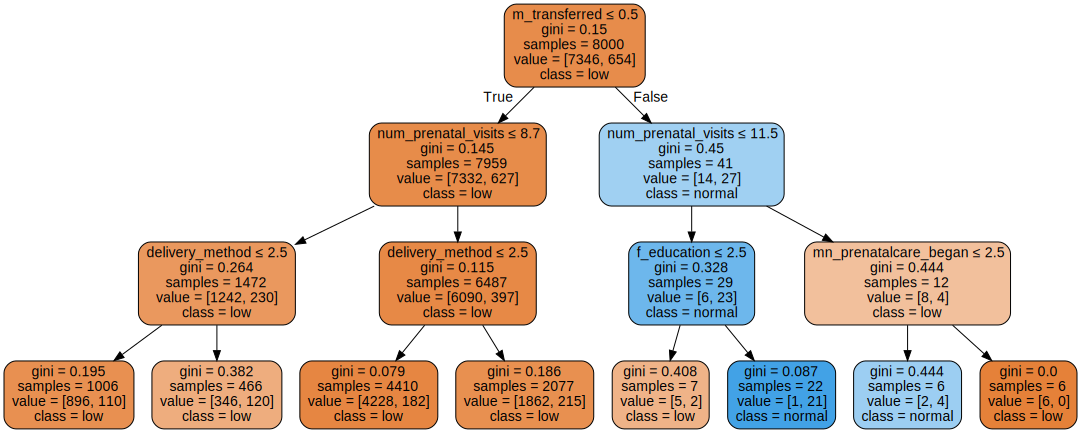

In [64]:
dt = DecisionTreeClassifier(max_depth=3).fit(X_train2, y_train2)
y_pred2 = dt.predict(X_test2)

full_model_accuracy = metrics.accuracy_score(y_test2, y_pred2)
print(f'Accuracy: {full_model_accuracy}')
plot_tree(dt, X.columns, ['low','normal'])

In [66]:
# 'mean_test_score' returns the average score for each parameter value over the cv fold. 
accuracy_scores = GS_model.cv_results_['mean_test_score']
print(f"Mean accurary scores:{accuracy_scores}")

# Plot the best estimator found: GridSearchCV.best_estimator_ returns the model that performed the best.
best_dt = GS_model.best_estimator_
#plot_tree(best_dt)

Mean accurary scores:[0.9188758  0.9186254  0.91937541 0.91875095 0.91612595 0.91487774
 0.91487774 0.91100056 0.90687555 0.90324852]


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.666


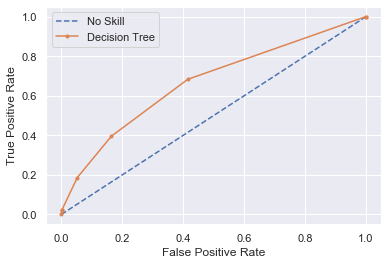

In [68]:
ns_probs = [0 for _ in range(len(y_test2))]

# predict probabilities
dt_probs = dt.predict_proba(X_test2)

# keep probabilities for the positive outcome only
dt_probs = dt_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test2, ns_probs)
dt_auc = roc_auc_score(y_test2, dt_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (dt_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
GS_model = GridSearchCV(RandomForestClassifier(), 
                        {'max_depth':[10, 200, 500, 700, 900, 1000]})

GS_model.fit(X_train2, y_train2)
GS_model.best_params_

{'max_depth': 500}

In [72]:
rfc = RandomForestClassifier(max_depth=500)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [73]:
y_pred = rfc.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1815    8]
 [ 146   31]]


In [ ]:
print('Number of low-bw cases in test set =', cm[1,0] + cm[1,1])
print('Number of correctly predicted low-bw cases =', cm[1,1])

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.842


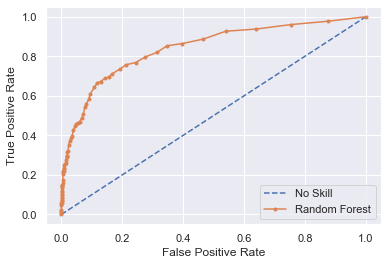

In [74]:
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
rfc_probs = rfc.predict_proba(X_test)

# keep probabilities for the positive outcome only
rfc_probs = rfc_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rfc_auc = roc_auc_score(y_test, rfc_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rfc_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Gradient Boosting

In [106]:
from lightgbm import LGBMClassifier

In [105]:
lgbm = GridSearchCV(LGBMClassifier(), 
                        {'num_leaves':[1, 5, 10, 30, 50, 70]})

lgbm.fit(X_train, y_train)
lgbm.best_params_

C:\Users\catri\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: num_leaves >1 at D:\a\1\s\python-package\compile\src\io\config_auto.cpp, line 304 .


  FitFailedWarning)
C:\Users\catri\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: num_leaves >1 at D:\a\1\s\python-package\compile\src\io\config_auto.cpp, line 304 .


  FitFailedWarning)
C:\Users\catri\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
lightgbm.basic.LightGBMError: Check failed: num_leav

{'num_leaves': 50}

In [117]:
gbm = LGBMClassifier()
gbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [118]:
y_pred = gbm.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1803   20]
 [ 130   47]]


No Skill: ROC AUC=0.500
Light Gradient Boost: ROC AUC=0.857


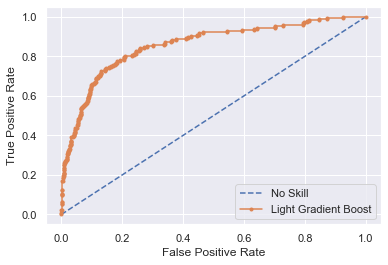

In [119]:
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
gbm_probs = gbm.predict_proba(X_test)

# keep probabilities for the positive outcome only
gbm_probs = gbm_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
gbm_auc = roc_auc_score(y_test, gbm_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Light Gradient Boost: ROC AUC=%.3f' % (gbm_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
gbm_fpr, gbm_tpr, _ = roc_curve(y_test, gbm_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(gbm_fpr, gbm_tpr, marker='.', label='Light Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [95]:
gbm2 = GradientBoostingClassifier()
gbm2.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [96]:
y_pred = gbm2.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[1802   21]
 [ 131   46]]


No Skill: ROC AUC=0.500
Gradient Boost: ROC AUC=0.857


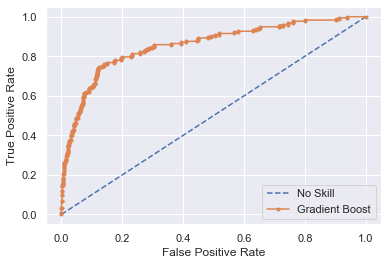

In [97]:
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
gbm2_probs = gbm2.predict_proba(X_test)

# keep probabilities for the positive outcome only
gbm2_probs = gbm2_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
gbm2_auc = roc_auc_score(y_test, gbm2_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Gradient Boost: ROC AUC=%.3f' % (gbm2_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
gbm2_fpr, gbm2_tpr, _ = roc_curve(y_test, gbm2_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(gbm2_fpr, gbm2_tpr, marker='.', label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Pipeline from Kaggle

In [93]:
from sklearn import model_selection 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier, GradientBoostingClassifier, 
                              VotingClassifier) 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time

In [94]:
start = time.time()
for model in [
    DummyClassifier, 
    LogisticRegression, 
    SGDClassifier,
    DecisionTreeClassifier, 
    KNeighborsClassifier,
    GaussianNB, 
    QuadraticDiscriminantAnalysis,
    # SVC, # Takes a long time
    RandomForestClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier, 
    GradientBoostingClassifier,
    XGBClassifier,
    LGBMClassifier
]:
    cls = model()
    kfold = model_selection.KFold(n_splits=10)
    start_t = time.time()
    s = model_selection.cross_val_score(cls, X_train, y_train, 
                                        scoring='roc_auc', cv=kfold, n_jobs=-1)
    training_time = time.time() - start_t 
    print("{:32}  AUC:{:.3f} STD: {:.2f} Time: {:.2f}".format(model.__name__, 
                                                              s.mean(), 
                                                              s.std(), 
                                                              training_time))

DummyClassifier                   AUC:0.493 STD: 0.02 Time: 8.05
LogisticRegression                AUC:0.858 STD: 0.04 Time: 1.08
SGDClassifier                     AUC:0.808 STD: 0.03 Time: 0.98
DecisionTreeClassifier            AUC:0.626 STD: 0.03 Time: 15.65
KNeighborsClassifier              AUC:0.698 STD: 0.04 Time: 13.35
GaussianNB                        AUC:0.764 STD: 0.03 Time: 0.43
QuadraticDiscriminantAnalysis     AUC:0.724 STD: 0.04 Time: 0.69
RandomForestClassifier            AUC:0.841 STD: 0.04 Time: 65.17
AdaBoostClassifier                AUC:0.827 STD: 0.03 Time: 35.56
ExtraTreesClassifier              AUC:0.820 STD: 0.04 Time: 20.91
GradientBoostingClassifier        AUC:0.850 STD: 0.04 Time: 144.79
XGBClassifier                     AUC:0.831 STD: 0.04 Time: 117.90
LGBMClassifier                    AUC:0.844 STD: 0.04 Time: 19.18


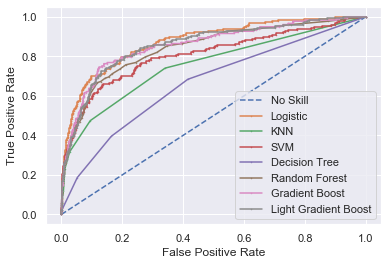

In [127]:
# Plot all roc curves above on one graph

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', markersize=1)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN', markersize=1)
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM', markersize=1)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree', markersize=1)
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='Random Forest', markersize=1)
plt.plot(gbm2_fpr, gbm2_tpr, marker='.', label='Gradient Boost', markersize=1)
plt.plot(gbm_fpr, gbm_tpr, marker='.', label='Light Gradient Boost', markersize=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#plt.savefig('Results/ROC_curves')

In [121]:
folds = KFold(n_splits=5, shuffle=True, random_state=42).split(X_train, y_train)
param_grid = {
    'num_leaves': [30, 120],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }
lgb_estimator = LGBMClassifier(boosting_type='gbdt',
                               objective='binary', 
                               num_boost_round=2000, 
                               learning_rate=0.01, 
                               metric='auc')
grid = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=folds)
lgb_model = grid.fit(X_train, y_train)

print(lgb_model.best_params_, lgb_model.best_score_)
#lgbmc = LGBMClassifier()

C:\Users\catri\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


KeyboardInterrupt: 

In [122]:
lgbmc = LGBMClassifier()
lgbmc.fit(X_train, y_train)

print(classification_report(y_test, lgbmc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1823
           1       0.70      0.27      0.39       177

    accuracy                           0.93      2000
   macro avg       0.82      0.63      0.67      2000
weighted avg       0.91      0.93      0.91      2000

